# Descriptive analysis of stroke pathway data

**Note:** Descriptive analysis will typically only be done on the dataset of patients who arrived within 4 hours of known stroke onset, but this notebook also includes results from the wider dataset (only restricted by admissions per year), with further restrictions specified.

## Set up

In [1]:
# Import packages and functions
import collections
from dataclasses import dataclass
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

# Set max rows when display dataframe
pd.set_option('display.max_rows', 100)

# Linting
%load_ext pycodestyle_magic
%pycodestyle_on

In [2]:
# Set paths and filenames
@dataclass(frozen=True)
class Paths:
    '''Singleton object for storing paths to data and files.'''

    data_path = './../output/'
    data_filename = 'reformatted_data.csv'
    admission_only_filename = 'reformatted_data_admissions_only.csv'
    notebook = '01'


paths = Paths()

In [3]:
# Load data
data = pd.read_csv(os.path.join(paths.data_path, paths.data_filename))
data_full = pd.read_csv(os.path.join(paths.data_path,
                                     paths.admission_only_filename))

## Overview of dataset

In [4]:
# Show shape of the data
print(f'Data shape (arrive <4hr known onset): {data.shape}')
print(f'Data shape (full dataset): {data_full.shape}')

Data shape (arrive <4hr known onset): (137019, 70)
Data shape (full dataset): (358884, 70)


In [5]:
# List all columns and show their data types and proportion of completed data
pd.DataFrame({
    'Data type': data.dtypes,
    'Proportion complete (full)': data_full.count() / data_full.shape[0],
    'Proportion complete (<4hr known)': data.count() / data.shape[0]})

,Data type,Proportion complete (full),Proportion complete (<4hr known)
id,int64,1.000000,1.000000
stroke_team,object,1.000000,1.000000
age,float64,1.000000,1.000000
male,int64,1.000000,1.000000
infarction,float64,1.000000,1.000000
onset_to_arrival_time,float64,0.670139,1.000000
onset_known,int64,1.000000,1.000000
precise_onset_known,int64,1.000000,1.000000
onset_during_sleep,int64,1.000000,1.000000
arrive_by_ambulance,float64,0.999980,0.999956


In [6]:
# Printing change in number of records due to restricting years
print(f'''
Number of records per year (full dataset):
{data_full.year.value_counts().sort_index().to_string()}
Number of records per year (arrive <4hr known onset):
{data.year.value_counts().sort_index().to_string()}''')


Number of records per year (full dataset):
2016    56210
2017    58726
2018    58281
2019    60177
2020    59082
2021    66408
Number of records per year (arrive <4hr known onset):
2016    22419
2017    23017
2018    22737
2019    23000
2020    22083
2021    23763


## SAMueL-1 analysis

### Summary tables

These summarise across the whole time period (2016-2021), including years in which stroke teams had a sufficient number of admissions.

In [7]:
def analyse_by_team(dataframe):
    '''
    Analyse data by stroke team
    '''
    # Create empty dictionary with default entry as list
    # (defaultdict means if no key, it will add one)
    res = collections.defaultdict(list)

    # Loop through stroke teams
    groups = dataframe.groupby('stroke_team')
    for team, group_df in groups:

        # Analysis on full dataset
        res['stroke_team'].append(team)
        res['n_arrivals_all'].append(len(group_df.index))
        res['prop_thrombolysis_all'].append(
            (group_df['thrombolysis'].dropna() == 1).mean())
        res['mean_rankin_before_stroke_all'].append(
            group_df['prior_disability'].dropna().mean())
        res['mean_nihss_on_arrival_all'].append(
            group_df['stroke_severity'].dropna().mean())
        res['prop_onset_known_all'].append(
            (group_df['onset_known'].dropna() == 1).mean())

        # Analysis on dataset with only onset known
        df_known = group_df[group_df['onset_known'] == 1]
        res['prop_known_onset_to_arrival_4h_or_less_all'].append(
            (df_known['onset_to_arrival_time'].dropna() <= 4*60).mean())

        # Analysis on dataset with known onset to arrival <= 4 hours
        df_known_4hr = df_known[df_known['onset_to_arrival_time'] <= 4*60]
        res['mean_rankin_before_stroke_4h_known'].append(
            df_known_4hr['prior_disability'].dropna().mean())
        res['mean_nihss_on_arrival_4h_known'].append(
            df_known_4hr['stroke_severity'].dropna().mean())
        res['prop_80_plus_4h_known'].append(
            (df_known_4hr['age'].dropna() >= 80).mean())
        res['mean_onset_to_arrival'].append(
            df_known_4hr['onset_to_arrival_time'].dropna().mean())
        res['std_onset_to_arrival'].append(
            df_known_4hr['onset_to_arrival_time'].dropna().std())
        scan_mask = df_known_4hr['arrival_to_scan_time'].dropna() <= 4*60
        res['prop_arrival_to_scan_4h_or_less_4h_known'].append(
            scan_mask.mean())

        # Analysis on dataset with scan within 4 hours arrival and known
        # onset to arrival <=4 hours
        df_known_4hr_scan = df_known_4hr[scan_mask]
        res['mean_arrival_to_scan_4h_known_4h_scan'].append(
            df_known_4hr_scan['arrival_to_scan_time'].dropna().mean())
        res['std_arrival_to_scan_4h_known_4h_scan'].append(
            df_known_4hr_scan['arrival_to_scan_time'].dropna().std())
        thrombolysed_mask = df_known_4hr_scan['thrombolysis'].dropna() == 1
        res['prop_thrombolysis_4h_known_4h_scan'].append(
            thrombolysed_mask.mean())

        # Analysis on dataset with thrombolysis, scan within 4 hours arrival,
        # and known onset to arrival <= 4 hours
        df_thrombolysed = df_known_4hr_scan[thrombolysed_mask]

        # Mean and std scan to thrombolysis
        res['mean_scan_to_thrombolysis_4h_known_4h_scan_t'].append(
            df_thrombolysed['scan_to_thrombolysis_time'].dropna().mean())
        res['std_scan_to_thrombolysis_4h_known_4h_scan_t'].append(
            df_thrombolysed['scan_to_thrombolysis_time'].dropna().std())

        # Mean and std arrival to thrombolysis
        arrival_to_thrombolysis = (
            df_thrombolysed['arrival_to_scan_time'] +
            df_thrombolysed['scan_to_thrombolysis_time'])
        res['mean_arrival_to_thrombolysis_4h_known_4h_scan_t'].append(
            arrival_to_thrombolysis.dropna().mean())
        res['std_arrival_to_thrombolysis_4h_known_4h_scan_t'].append(
            arrival_to_thrombolysis.dropna().std())

        # Mean and std onset to thrombolysis
        onset_to_thrombolysis = (df_thrombolysed['onset_to_arrival_time'] +
                                 arrival_to_thrombolysis)
        res['mean_onset_to_thrombolysis_4h_known_4h_scan_t'].append(
            onset_to_thrombolysis.dropna().mean())
        res['std_onset_to_thrombolysis_4h_known_4h_scan_t'].append(
            onset_to_thrombolysis.dropna().std())

        # Proportion of thrombolysis that were after 180 min or 270 min
        (res['prop_thrombolysis_onset_treat_over_180_4h_known_4h_scan_t']
         .append((onset_to_thrombolysis.dropna() > 180).mean()))
        (res['prop_thrombolysis_onset_treat_over_270_4h_known_4h_scan_t']
         .append((onset_to_thrombolysis.dropna() > 270).mean()))

    return pd.DataFrame(res)

In [8]:
# Results by team
res_team = analyse_by_team(data_full)
display(res_team.head())

# Find averages from the team results
display(res_team.drop('stroke_team', axis=1).describe().T)

# Summarise entire dataset (analyse all patients together)
data_full_all = data_full.copy()
data_full_all['stroke_team'] = 'All'
res_all = analyse_by_team(data_full_all)
display(res_all)

,stroke_team,n_arrivals_all,prop_thrombolysis_all,mean_rankin_before_stroke_all,mean_nihss_on_arrival_all,prop_onset_known_all,prop_known_onset_to_arrival_4h_or_less_all,mean_rankin_before_stroke_4h_known,mean_nihss_on_arrival_4h_known,prop_80_plus_4h_known,...,std_arrival_to_scan_4h_known_4h_scan,prop_thrombolysis_4h_known_4h_scan,mean_scan_to_thrombolysis_4h_known_4h_scan_t,std_scan_to_thrombolysis_4h_known_4h_scan_t,mean_arrival_to_thrombolysis_4h_known_4h_scan_t,std_arrival_to_thrombolysis_4h_known_4h_scan_t,mean_onset_to_thrombolysis_4h_known_4h_scan_t,std_onset_to_thrombolysis_4h_known_4h_scan_t,prop_thrombolysis_onset_treat_over_180_4h_known_4h_scan_t,prop_thrombolysis_onset_treat_over_270_4h_known_4h_scan_t
0,Addenbrooke's Hospital,3591,0.150097,0.791423,6.537176,0.592036,0.679210,0.799169,8.472299,0.443906,...,42.681575,0.376000,25.402321,25.067363,59.413926,31.430415,161.125725,54.300428,0.334623,0.029014
1,Basildon University Hospital,2917,0.132328,0.740487,5.642784,0.648269,0.572713,0.739612,6.972299,0.383195,...,46.134821,0.356455,37.410811,23.441304,53.462162,31.568138,152.418919,52.978138,0.272973,0.027027
2,Blackpool Victoria Hospital,2901,0.092382,0.991727,7.980696,0.450190,0.692956,1.051934,10.074033,0.408840,...,41.144215,0.283705,41.264463,30.025098,72.933884,38.878838,157.933884,54.241390,0.297521,0.024793
3,Bradford and Airedale SU,3535,0.075530,1.030269,7.464498,0.442150,0.641075,0.949102,9.555888,0.344311,...,49.048408,0.265823,54.218254,29.419686,87.619048,39.034739,184.206349,51.560017,0.476190,0.047619
4,Bronglais Hospital,585,0.232479,0.769231,7.355556,0.876923,0.497076,0.800000,8.788235,0.435294,...,37.915858,0.531746,42.738806,24.904307,53.283582,27.387120,176.313433,56.819781,0.440299,0.037313


,count,mean,std,min,25%,50%,75%,max
n_arrivals_all,119.0,3015.831933,1234.298520,493.000000,2214.000000,2901.000000,3698.500000,7102.000000
prop_thrombolysis_all,119.0,0.115455,0.033976,0.020290,0.092255,0.112471,0.132787,0.249667
mean_rankin_before_stroke_all,119.0,1.019735,0.246691,0.292089,0.868008,1.014577,1.205907,1.582249
mean_nihss_on_arrival_all,119.0,7.068939,0.969051,4.528681,6.353663,7.256352,7.859639,9.300537
prop_onset_known_all,119.0,0.676087,0.130226,0.413687,0.583768,0.675706,0.753146,0.991561
prop_known_onset_to_arrival_4h_or_less_all,119.0,0.578963,0.090581,0.311774,0.525064,0.591662,0.643129,0.783972
mean_rankin_before_stroke_4h_known,119.0,1.036844,0.244880,0.371429,0.868353,1.021297,1.207830,1.592755
mean_nihss_on_arrival_4h_known,119.0,8.945415,1.046782,6.380626,8.232910,9.066451,9.596998,11.196221
prop_80_plus_4h_known,119.0,0.407762,0.059048,0.234705,0.368235,0.410435,0.448383,0.562155
mean_onset_to_arrival,119.0,114.203466,6.811043,98.469146,110.458714,114.085392,118.737195,135.595745


,stroke_team,n_arrivals_all,prop_thrombolysis_all,mean_rankin_before_stroke_all,mean_nihss_on_arrival_all,prop_onset_known_all,prop_known_onset_to_arrival_4h_or_less_all,mean_rankin_before_stroke_4h_known,mean_nihss_on_arrival_4h_known,prop_80_plus_4h_known,...,std_arrival_to_scan_4h_known_4h_scan,prop_thrombolysis_4h_known_4h_scan,mean_scan_to_thrombolysis_4h_known_4h_scan_t,std_scan_to_thrombolysis_4h_known_4h_scan_t,mean_arrival_to_thrombolysis_4h_known_4h_scan_t,std_arrival_to_thrombolysis_4h_known_4h_scan_t,mean_onset_to_thrombolysis_4h_known_4h_scan_t,std_onset_to_thrombolysis_4h_known_4h_scan_t,prop_thrombolysis_onset_treat_over_180_4h_known_4h_scan_t,prop_thrombolysis_onset_treat_over_270_4h_known_4h_scan_t
0,All,358884,0.114636,1.032919,7.061209,0.670139,0.569721,1.045928,8.919821,0.406469,...,44.084671,0.306746,37.117152,28.606804,60.134559,35.194937,159.439289,54.783185,0.318341,0.020578


In [9]:
# Analyse by under 80 v.s. 80 or older

# By team then average
res_under_80 = analyse_by_team(data_full[data_full['age'] < 80])
res_80_plus = analyse_by_team(data_full[data_full['age'] >= 80])
display(res_under_80.head())
display(res_80_plus.head())
display(res_under_80.describe().T)
display(res_80_plus.describe().T)

# All patients together
res_all_under_80 = analyse_by_team(
    data_full_all[data_full_all['age'] < 80])
res_all_80_plus = analyse_by_team(
    data_full_all[data_full_all['age'] >= 80])
display(res_all_under_80)
display(res_all_80_plus)

,stroke_team,n_arrivals_all,prop_thrombolysis_all,mean_rankin_before_stroke_all,mean_nihss_on_arrival_all,prop_onset_known_all,prop_known_onset_to_arrival_4h_or_less_all,mean_rankin_before_stroke_4h_known,mean_nihss_on_arrival_4h_known,prop_80_plus_4h_known,...,std_arrival_to_scan_4h_known_4h_scan,prop_thrombolysis_4h_known_4h_scan,mean_scan_to_thrombolysis_4h_known_4h_scan_t,std_scan_to_thrombolysis_4h_known_4h_scan_t,mean_arrival_to_thrombolysis_4h_known_4h_scan_t,std_arrival_to_thrombolysis_4h_known_4h_scan_t,mean_onset_to_thrombolysis_4h_known_4h_scan_t,std_onset_to_thrombolysis_4h_known_4h_scan_t,prop_thrombolysis_onset_treat_over_180_4h_known_4h_scan_t,prop_thrombolysis_onset_treat_over_270_4h_known_4h_scan_t
0,Addenbrooke's Hospital,2022,0.162710,0.508408,5.431751,0.604352,0.657119,0.464508,7.179328,0.0,...,43.066987,0.406780,24.307692,21.261839,59.224359,29.417293,161.769231,54.432866,0.346154,0.022436
1,Basildon University Hospital,1780,0.144944,0.394382,4.738764,0.682022,0.550247,0.380240,6.131737,0.0,...,44.838046,0.383540,38.311741,24.030214,55.502024,33.893170,154.360324,53.757546,0.287449,0.028340
2,Blackpool Victoria Hospital,1776,0.106982,0.645833,6.806869,0.449324,0.670426,0.635514,8.865421,0.0,...,41.462814,0.331384,42.252941,28.779114,76.035294,39.910832,160.288235,54.749612,0.317647,0.017647
3,Bradford and Airedale SU,2250,0.088889,0.742667,6.598667,0.460444,0.634170,0.666667,8.856925,0.0,...,47.957487,0.306709,54.604167,29.594813,88.812500,39.775499,183.708333,50.568272,0.468750,0.041667
4,Bronglais Hospital,336,0.238095,0.369048,6.139881,0.892857,0.480000,0.326389,7.833333,0.0,...,34.777251,0.556338,43.126582,27.434475,53.835443,29.770675,175.721519,59.275960,0.417722,0.037975


,stroke_team,n_arrivals_all,prop_thrombolysis_all,mean_rankin_before_stroke_all,mean_nihss_on_arrival_all,prop_onset_known_all,prop_known_onset_to_arrival_4h_or_less_all,mean_rankin_before_stroke_4h_known,mean_nihss_on_arrival_4h_known,prop_80_plus_4h_known,...,std_arrival_to_scan_4h_known_4h_scan,prop_thrombolysis_4h_known_4h_scan,mean_scan_to_thrombolysis_4h_known_4h_scan_t,std_scan_to_thrombolysis_4h_known_4h_scan_t,mean_arrival_to_thrombolysis_4h_known_4h_scan_t,std_arrival_to_thrombolysis_4h_known_4h_scan_t,mean_onset_to_thrombolysis_4h_known_4h_scan_t,std_onset_to_thrombolysis_4h_known_4h_scan_t,prop_thrombolysis_onset_treat_over_180_4h_known_4h_scan_t,prop_thrombolysis_onset_treat_over_270_4h_known_4h_scan_t
0,Addenbrooke's Hospital,1569,0.133843,1.156150,7.961759,0.576163,0.709071,1.218409,10.092044,1.0,...,42.224864,0.337171,27.068293,29.926793,59.702439,34.341198,160.146341,54.216596,0.317073,0.039024
1,Basildon University Hospital,1137,0.112577,1.282322,7.058047,0.595427,0.612999,1.318072,8.325301,1.0,...,48.236964,0.312183,35.601626,22.196492,49.365854,25.932216,148.520325,51.371094,0.243902,0.024390
2,Blackpool Victoria Hospital,1125,0.069333,1.537778,9.833778,0.451556,0.728346,1.654054,11.821622,1.0,...,40.714297,0.211765,38.930556,32.874634,65.611111,35.523274,152.375000,52.982175,0.250000,0.041667
3,Bradford and Airedale SU,1285,0.052140,1.533852,8.980545,0.410117,0.654649,1.486957,10.886957,1.0,...,50.892954,0.186335,52.983333,29.063631,83.800000,36.620731,185.800000,55.027204,0.500000,0.066667
4,Bronglais Hospital,249,0.224900,1.309237,8.995984,0.855422,0.521127,1.414414,10.027027,1.0,...,41.653110,0.500000,42.181818,20.973609,52.490909,23.792212,177.163636,53.620326,0.472727,0.036364


,count,mean,std,min,25%,50%,75%,max
n_arrivals_all,119.0,1819.697479,799.593239,336.000000,1275.500000,1775.000000,2268.000000,5004.000000
prop_thrombolysis_all,119.0,0.126791,0.034874,0.012987,0.104105,0.123902,0.148361,0.259569
mean_rankin_before_stroke_all,119.0,0.635975,0.188122,0.184783,0.508993,0.620424,0.774716,1.142073
mean_nihss_on_arrival_all,119.0,5.921475,0.891888,3.854593,5.247939,5.964168,6.644370,8.159403
prop_onset_known_all,119.0,0.685974,0.126923,0.437428,0.596979,0.684371,0.757962,0.991202
prop_known_onset_to_arrival_4h_or_less_all,119.0,0.563262,0.091871,0.237143,0.507601,0.577328,0.628104,0.770171
mean_rankin_before_stroke_4h_known,119.0,0.604105,0.190896,0.173913,0.469974,0.590000,0.737910,1.119186
mean_nihss_on_arrival_4h_known,119.0,7.813652,1.050508,5.399031,7.164010,7.833333,8.611201,10.391534
prop_80_plus_4h_known,119.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
mean_onset_to_arrival,119.0,111.857637,7.426859,96.391167,106.942200,111.283505,115.842028,144.120482


,count,mean,std,min,25%,50%,75%,max
n_arrivals_all,119.0,1196.134454,489.380202,125.000000,857.500000,1171.000000,1483.000000,2550.000000
prop_thrombolysis_all,119.0,0.098471,0.035241,0.028226,0.072092,0.095391,0.117430,0.234501
mean_rankin_before_stroke_all,119.0,1.595962,0.318412,0.608000,1.435581,1.599273,1.811544,2.237792
mean_nihss_on_arrival_all,119.0,8.807297,1.106057,5.935936,8.008114,9.054757,9.572223,11.869624
prop_onset_known_all,119.0,0.662675,0.136160,0.386152,0.558433,0.663731,0.738517,0.992048
prop_known_onset_to_arrival_4h_or_less_all,119.0,0.604613,0.091897,0.364583,0.550191,0.615187,0.664586,0.805627
mean_rankin_before_stroke_4h_known,119.0,1.665625,0.318001,0.729730,1.464976,1.677892,1.895000,2.343849
mean_nihss_on_arrival_4h_known,119.0,10.602032,1.184405,7.888337,9.907297,10.814249,11.370535,13.134921
prop_80_plus_4h_known,119.0,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
mean_onset_to_arrival,119.0,117.645573,7.087925,97.486726,113.336034,117.218911,122.203653,137.872852


,stroke_team,n_arrivals_all,prop_thrombolysis_all,mean_rankin_before_stroke_all,mean_nihss_on_arrival_all,prop_onset_known_all,prop_known_onset_to_arrival_4h_or_less_all,mean_rankin_before_stroke_4h_known,mean_nihss_on_arrival_4h_known,prop_80_plus_4h_known,...,std_arrival_to_scan_4h_known_4h_scan,prop_thrombolysis_4h_known_4h_scan,mean_scan_to_thrombolysis_4h_known_4h_scan_t,std_scan_to_thrombolysis_4h_known_4h_scan_t,mean_arrival_to_thrombolysis_4h_known_4h_scan_t,std_arrival_to_thrombolysis_4h_known_4h_scan_t,mean_onset_to_thrombolysis_4h_known_4h_scan_t,std_onset_to_thrombolysis_4h_known_4h_scan_t,prop_thrombolysis_onset_treat_over_180_4h_known_4h_scan_t,prop_thrombolysis_onset_treat_over_270_4h_known_4h_scan_t
0,All,216544,0.126681,0.646959,5.906818,0.680915,0.55155,0.60846,7.798488,0.0,...,43.918171,0.343731,37.393218,29.23095,60.904565,36.20439,159.753948,55.699976,0.323217,0.02142


,stroke_team,n_arrivals_all,prop_thrombolysis_all,mean_rankin_before_stroke_all,mean_nihss_on_arrival_all,prop_onset_known_all,prop_known_onset_to_arrival_4h_or_less_all,mean_rankin_before_stroke_4h_known,mean_nihss_on_arrival_4h_known,prop_80_plus_4h_known,...,std_arrival_to_scan_4h_known_4h_scan,prop_thrombolysis_4h_known_4h_scan,mean_scan_to_thrombolysis_4h_known_4h_scan_t,std_scan_to_thrombolysis_4h_known_4h_scan_t,mean_arrival_to_thrombolysis_4h_known_4h_scan_t,std_arrival_to_thrombolysis_4h_known_4h_scan_t,mean_onset_to_thrombolysis_4h_known_4h_scan_t,std_onset_to_thrombolysis_4h_known_4h_scan_t,prop_thrombolysis_onset_treat_over_180_4h_known_4h_scan_t,prop_thrombolysis_onset_treat_over_270_4h_known_4h_scan_t
0,All,142340,0.096312,1.620086,8.817402,0.653745,0.598513,1.684724,10.557205,1.0,...,44.317036,0.252614,36.567352,27.314097,58.601046,33.040853,158.812626,52.906515,0.308629,0.018902


### Summary figure

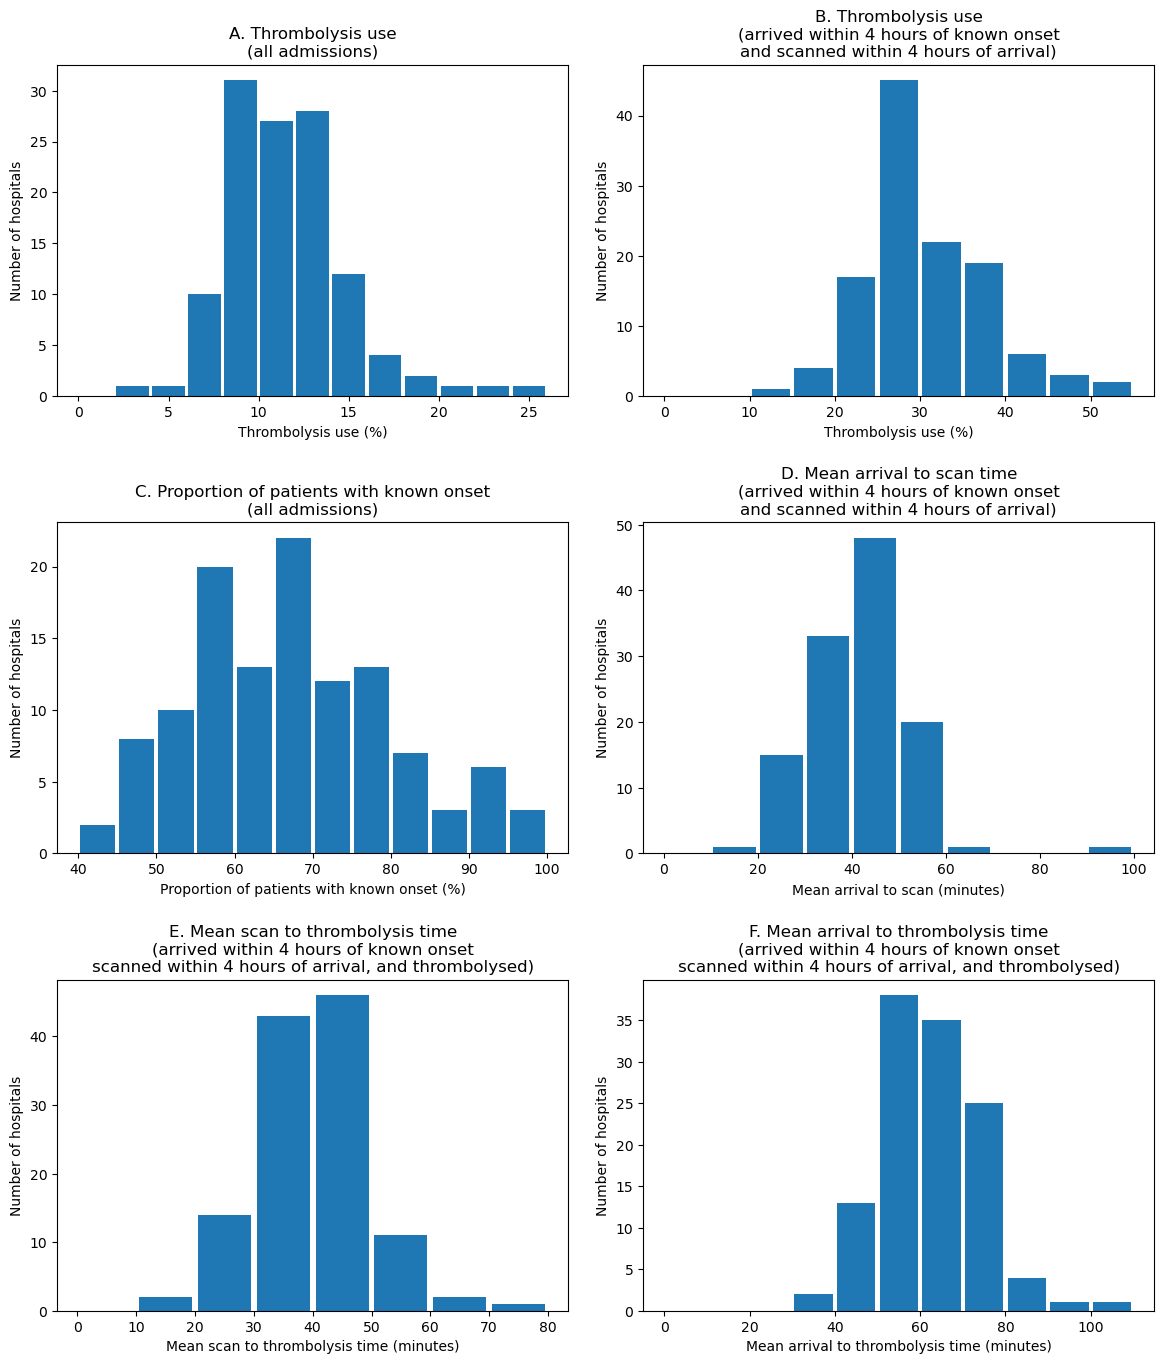

In [10]:
# Set up figure
fig, ax = plt.subplots(3, 2, figsize=(12, 14))

# Plot of thrombolysis rate
x = res_team['prop_thrombolysis_all'] * 100
bins = np.arange(start=0, stop=x.max()+2, step=2)
ax[0, 0].hist(x, bins=bins, rwidth=0.9)
ax[0, 0].set_xlabel('Thrombolysis use (%)')
ax[0, 0].set_ylabel('Number of hospitals')
ax[0, 0].set_title('A. Thrombolysis use\n(all admissions)')

# Plot of thrombolysis rate (4hr known onset, 4hr scan)
x = res_team['prop_thrombolysis_4h_known_4h_scan'] * 100
bins = np.arange(start=0, stop=x.max()+5, step=5)
ax[0, 1].hist(x, bins=bins, rwidth=0.9)
ax[0, 1].set_xlabel('Thrombolysis use (%)')
ax[0, 1].set_ylabel('Number of hospitals')
ax[0, 1].set_title('''B. Thrombolysis use
(arrived within 4 hours of known onset
and scanned within 4 hours of arrival)''')

# Plot of proportion of patients with known onset
x = res_team['prop_onset_known_all'] * 100
bins = np.arange(start=40, stop=x.max()+5, step=5)
ax[1, 0].hist(x, bins=bins, rwidth=0.9)
ax[1, 0].set_xlabel('Proportion of patients with known onset (%)')
ax[1, 0].set_ylabel('Number of hospitals')
ax[1, 0].set_title('''C. Proportion of patients with known onset
(all admissions)''')

# Plot of mean arrival to scan time (4hr known onset, 4hr scan)
x = res_team['mean_arrival_to_scan_4h_known_4h_scan']
bins = np.arange(0, x.max()+10, 10)
ax[1, 1].hist(x, bins=bins, rwidth=0.9)
ax[1, 1].set_xlabel('Mean arrival to scan (minutes)')
ax[1, 1].set_ylabel('Number of hospitals')
ax[1, 1].set_title('''D. Mean arrival to scan time
(arrived within 4 hours of known onset
and scanned within 4 hours of arrival)''')

# Plot of mean scan to needle time
x = res_team['mean_scan_to_thrombolysis_4h_known_4h_scan_t']
bins = np.arange(0, x.max()+10, 10)
ax[2, 0].hist(x, bins=bins, rwidth=0.9)
ax[2, 0].set_xlabel('Mean scan to thrombolysis time (minutes)')
ax[2, 0].set_ylabel('Number of hospitals')
ax[2, 0].set_title('''E. Mean scan to thrombolysis time
(arrived within 4 hours of known onset
scanned within 4 hours of arrival, and thrombolysed)''')

# Plot of mean arrival to needle time
x = res_team['mean_arrival_to_thrombolysis_4h_known_4h_scan_t']
bins = np.arange(0, x.max()+10, 10)
ax[2, 1].hist(x, bins=bins, rwidth=0.9)
ax[2, 1].set_xlabel('Mean arrival to thrombolysis time (minutes)')
ax[2, 1].set_ylabel('Number of hospitals')
ax[2, 1].set_title('''F. Mean arrival to thrombolysis time
(arrived within 4 hours of known onset
scanned within 4 hours of arrival, and thrombolysed)''')

# Show figure
plt.tight_layout(pad=2)
plt.show()

## Admissions

Restricted dataset

In [11]:
# Total admissions
len(data.index)

137019

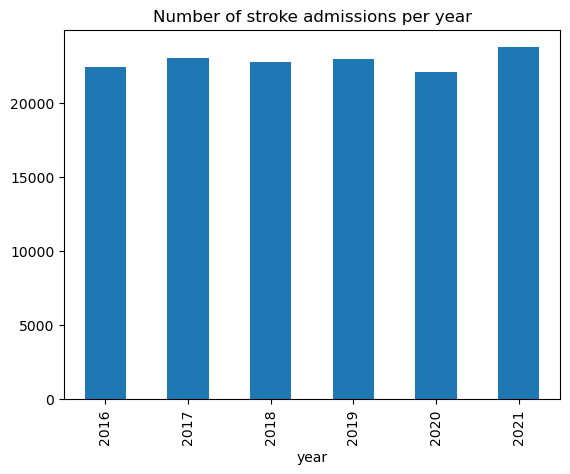

In [12]:
# Admissions per year
yearly_admissions = data.groupby('year').size().reset_index(name='admissions')
yearly_admissions.plot.bar(x='year', y='admissions',
                           title='Number of stroke admissions per year',
                           legend=None)
plt.show()

In [13]:
# Mean admissions per year
round(yearly_admissions['admissions'].mean(), 2)

22836.5

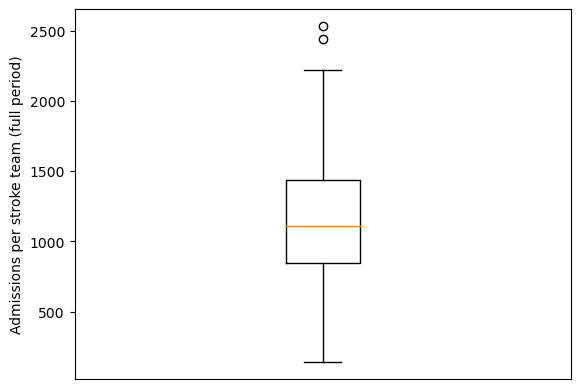

In [14]:
# Admissions per stroke team
team_admissions = data.groupby('stroke_team').size()

# Plot distribution of admissions
plt.boxplot(team_admissions)
plt.ylabel('Admissions per stroke team (full period)')

# Remove x axis ticks as only one variable
plt.tick_params(axis='x', which='both', bottom=False,
                top=False, labelbottom=False)

plt.show()

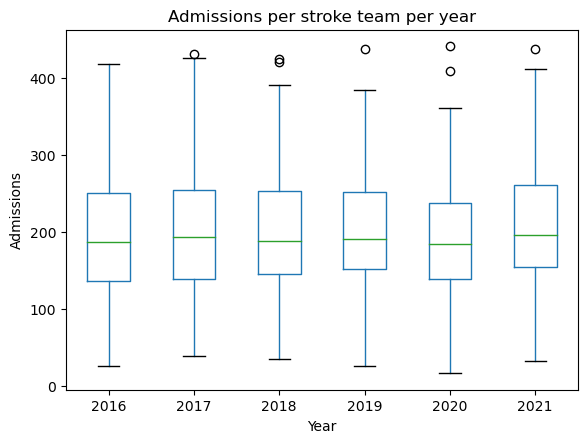

In [15]:
# Find number of admissions per stroke team per year
team_admissions_yearly = (data
                          .groupby(['stroke_team', 'year'])
                          .size()
                          .reset_index(name='admissions'))

# Plot per year
team_admissions_yearly.boxplot('admissions', by='year')
plt.xlabel('Year')
plt.ylabel('Admissions')
plt.title('Admissions per stroke team per year')
plt.suptitle('')
plt.grid(None)
plt.show()

## Stroke types

In [16]:
def n_freq(series):
    '''
    Finds value counts and their frequency
    Input series e.g. data[col], data[[col1, col2]],
    data.groupby(col1)[col2]
    '''
    res = pd.concat(
        [series.value_counts(dropna=False),
         series.value_counts(dropna=False, normalize=True)],
        axis=1,
        keys=('n', 'freq'))
    if res.index.nlevels > 1:
        res = res.reset_index()
    return (res)

In [17]:
n_freq(data['infarction'].map({1: 'Infarction',
                               0: 'Primary Intracerebral Haemorrage'}))

,n,freq
Infarction,116985,0.853787
Primary Intracerebral Haemorrage,20034,0.146213


## Thrombolysis and thrombectomy

In [18]:
# Thrombolysis use
n_freq(data['thrombolysis'])

,n,freq
0,96964,0.707668
1,40055,0.292332


In [19]:
# Thrombectomy use
n_freq(data['thrombectomy'])

,n,freq
0,133535,0.974573
1,3484,0.025427


In [20]:
# Thrombolysis and/or thrombectomy use
n_freq(data[['thrombolysis', 'thrombectomy']]).sort_values(by='thrombolysis')

,thrombolysis,thrombectomy,n,freq
0,0,0,95953,0.700290
3,0,1,1011,0.007379
1,1,0,37582,0.274283
2,1,1,2473,0.018049


In [21]:
# Arrival by ambulance
n_freq(data['arrive_by_ambulance'])

,n,freq
1.0,123839,0.903809
0.0,13174,0.096147
NaN,6,0.000044


In [22]:
# Thrombolysis use, depending on whether arrived by ambulance
(n_freq(data.groupby('arrive_by_ambulance')['thrombolysis'])
 .sort_values(by='arrive_by_ambulance'))

,arrive_by_ambulance,thrombolysis,n,freq
0,0.0,0,10149,0.770381
1,0.0,1,3025,0.229619
2,1.0,0,86810,0.700991
3,1.0,1,37029,0.299009


## Reasons for no thrombolysis

It is possible to have multiple reasons why no thrombolysis was given.

To do:
* What are the most common reasons
* How often is it a combination of reasons
* How often is no reason provided
* Double-check this is only complete when there was no thrombolysis
* Look further (e.g. subgroups, characteristics, associations)

In [23]:
(data[[col for col in data if col.startswith('thrombolysis_no')]]
 .value_counts(dropna=False)
 .reset_index(name='count'))

,thrombolysis_no_not_available,thrombolysis_no_out_of_hours,thrombolysis_no_scan_not_quick_enough,thrombolysis_no_no_reason,thrombolysis_no_but_haemorrhagic,thrombolysis_no_but_time_window,thrombolysis_no_but_comorbidity,thrombolysis_no_but_medication,thrombolysis_no_but_refusal,thrombolysis_no_but_age,thrombolysis_no_but_improving,thrombolysis_no_but_too_mild_severe,thrombolysis_no_but_time_unknown_wake_up,thrombolysis_no_but_other_medical,count
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,40055
1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,19947
2,0,0,0,0,0,0,0,0,0,0,0,1,0,0,12966
3,0,0,0,0,0,0,0,0,0,0,0,0,1,0,10838
4,0,0,0,0,0,0,0,0,0,0,0,0,0,1,9637
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
219,0,0,0,0,0,0,0,0,1,0,1,1,1,0,1
220,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1
221,0,0,0,0,0,0,0,0,1,1,0,1,0,0,1
222,0,0,0,0,1,0,0,1,0,0,0,0,1,1,1


## Disability at 6 months

Currently, outcome models are just based on discharge disability. The majority of patients are missing disability at 6 months - but this is not likely to be missing at random.

In [25]:
# tbc
# e.g. disability at discharge v.s. at 6 months, is it typically 1 mRS better

### Comparing patients who arrived by ambulance to those who did not

In [26]:
# Find counts arriving by ambulance or not
arrive_ambulance_stats = (
    data['arrive_by_ambulance']
    .map({0: 'Did not arrive by ambulance', 1: 'Arrived by ambulance'})
    .value_counts(dropna=False)
    .reset_index(name='count'))

# Find proportions
arrive_ambulance_stats['percentage'] = (
    arrive_ambulance_stats['count'] /
    arrive_ambulance_stats['count'].sum()*100)

arrive_ambulance_stats

,index,count,percentage
0,Arrived by ambulance,123839,90.380896
1,Did not arrive by ambulance,13174,9.614725
2,NaN,6,0.004379


#### Prior disability

Patients who arrived by ambulance typically had more severe strokes.

In [27]:
(data
 .groupby('arrive_by_ambulance')['prior_disability']
 .describe())

,count,mean,std,min,25%,50%,75%,max
arrive_by_ambulance,,,,,,,,
0.0,13174.0,0.551465,1.016624,0.0,0.0,0.0,1.0,5.0
1.0,123839.0,1.098467,1.433088,0.0,0.0,0.0,2.0,5.0


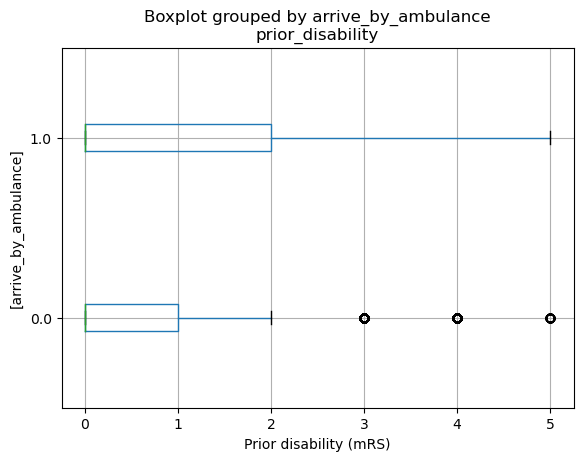

In [28]:
(data[['prior_disability', 'arrive_by_ambulance']]
 .boxplot(by='arrive_by_ambulance', vert=False))
plt.xlabel('Prior disability (mRS)')
plt.show()

,arrive_by_ambulance,prior_disability,count,proportion
0,0.0,0,9229,0.067359
1,0.0,1,2044,0.014918
2,0.0,2,863,0.006299
3,0.0,3,715,0.005218
4,0.0,4,265,0.001934
5,0.0,5,58,0.000423
6,1.0,0,66035,0.481962
7,1.0,1,19229,0.140344
8,1.0,3,15149,0.110566
9,1.0,2,12416,0.090619


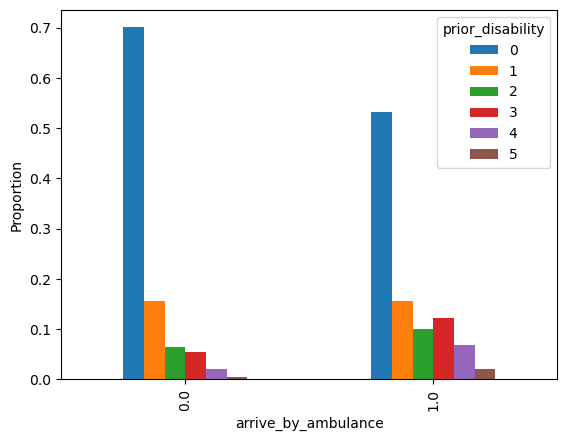

In [29]:
# Show counts and proportion of each mRS score
# (by whether arrived by ambulance)
amb_mrs = (data
           .groupby('arrive_by_ambulance')['prior_disability']
           .value_counts()
           .reset_index(name='count'))
amb_mrs['proportion'] = amb_mrs['count'] / amb_mrs['count'].sum()
display(amb_mrs)

# Create grouped bar plot based on proportions
(data
 .groupby('arrive_by_ambulance')['prior_disability']
 .value_counts(normalize=True)
 .unstack('prior_disability')
 .plot.bar())
plt.ylabel('Proportion')
plt.show()